# Producing figure 1

In [11]:
#!/usr/bin/env python
# coding: utf-8
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from tqdm import tqdm, trange
from utils import get_logs_and_files, convert_train_to_test_idx

In [12]:
# experiments = ['same_net', 'random_gates_only', 'train_to_criterion',  'random_gates_no_rehearsal','rehearsal','random_gates',  'correlated_gates', 'cognitive_observer', ]
folder_name = './../files/factorized/'
folder_name = './../files/final_policy_weaning/'
folder_name = './../files/final_bu2/'

In [13]:
# experiments = ['same_net', 'train_to_criterion', 'rehearsal', 'random_gates_mul',]
# experiments += ['random_gates_only', 'random_gates_no_rehearsal', 'random_gates_rehearsal_no_train_to_criterion'] #  

exps = ['same_net', 'random_gates_only', 'train_to_criterion', 'random_gates_no_rehearsal' , 'rehearsal','random_gates_mul',   'random_gates_rehearsal_no_train_to_criterion'  ]# ]# 'cognitive_observer', ]
exps_names= ['RNN', 'Task_ID',       'train to\ncriterion', 'Task_ID\n+ TTC' ,'Rehearsal\n+TTC', 'TTC+Reh\n+task_ID', 'no ttc']#  'cognitive_observer', ]
last_task_idx = [14, 14, 14, 14 ,118, 118, 118 ]# 'cognitive_observer', ]
accuracy_dict = {}
total_trials_dict={}
total_optimization_trials_dict={}
optimization_totals_by_reh_len_dict={}
average_acc_dict = {}
for i, exp_name in enumerate(exps):
    testing_logs, test_files = get_logs_and_files(folder_name, exp_name, file_sig='testing_log')
    training_logs, train_files = get_logs_and_files(folder_name, exp_name, file_sig='training_log')
    configs, config_files = get_logs_and_files(folder_name, exp_name, file_sig='config')
    mean_accuracies = []
    totals = []
    optimization_totals = []
    optimization_totals_by_reh_len = defaultdict(list)
    average_acc =[]
    for (testing_log, training_log,config) in (zip(testing_logs, training_logs, configs)):
            ## Get the testing log accuracies for the last trial of training. Getting complicated now there are rehearsal and optimzation trial after it
            # print(f'i is : {i}  len {len(training_log.switch_trialxxbatch)}')
            last_training_trial = training_log.switch_trialxxbatch[last_task_idx[i]] # Getting the time stamp for the last trial of trianing, depending on experiment setup either 14th or 118th task
            last_training_trial_nearest_test_point = convert_train_to_test_idx(training_log, testing_log, last_training_trial)

            final_accuracy_average = np.mean(list(testing_log.accuracies[last_training_trial_nearest_test_point].values()))
            mean_accuracies.append(final_accuracy_average)
            totals.append(last_training_trial)

            # optimization_totals.append(training_log.stamps[-1] - training_log.start_optimizing_at) # total trials spent in optimization
            no_of_optim_tasks = 40
            optim_ttcs = training_log.trials_to_crit[-no_of_optim_tasks:]
            optimization_totals.append(np.mean(optim_ttcs))
            optimization_totals_by_reh_len[config.random_rehearsals].append(np.mean(optim_ttcs))
            # print(config.random_rehearsals)
            # avg
            taa = []
            for logi in range(15):
                taa.append([test_acc[logi] for test_acc in testing_log.accuracies])
            average_acc.append(np.stack(taa))
        
    accuracy_dict.update({exp_name: np.stack(mean_accuracies)})
    total_trials_dict.update({exp_name: np.stack(totals)})
    average_acc_dict.update({exp_name: (average_acc)})
    total_optimization_trials_dict.update({exp_name: (optimization_totals)})
    optimization_totals_by_reh_len_dict.update({exp_name: (optimization_totals_by_reh_len)})

In [5]:
accuracy_dict

{'same_net': array([0.14444445, 0.15777777, 0.38666672, 0.43333334, 0.14666666],
       dtype=float32),
 'random_gates_only': array([0.15111113, 0.21333334, 0.30888888, 0.40000004, 0.15555555],
       dtype=float32),
 'train_to_criterion': array([0.13555557, 0.13111112, 0.30444443, 0.44888893, 0.22222224],
       dtype=float32),
 'random_gates_no_rehearsal': array([0.21333335, 0.22666666, 0.26666665, 0.3644444 , 0.21111111],
       dtype=float32),
 'rehearsal': array([0.28444442, 0.25333336, 0.47333336, 0.5622223 , 0.25555557],
       dtype=float32),
 'random_gates_mul': array([0.7511111, 0.8333333, 0.8155556, 0.8577778, 0.768889 ],
       dtype=float32),
 'random_gates_rehearsal_no_train_to_criterion': array([0.6488889, 0.7044445, 0.7155556, 0.8266668, 0.6022222],
       dtype=float32)}

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


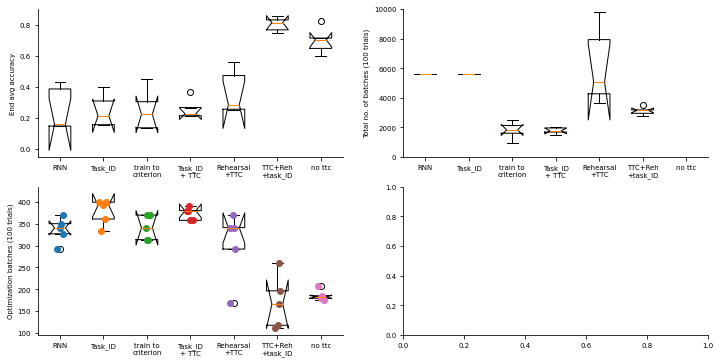

In [6]:
# exps = ['same_net', , 'train_to_criterion', 'rehearsal','random_gates_no_rehearsal' , 'random_gates_mul', ]# 'cognitive_observer', ]
fig, axes = plt.subplots(2,2, figsize=[12,6])
ax = axes[0,0]
_=ax.boxplot([accuracy_dict[exp] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
# _=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('End avg accuracy')

ax = axes[0,1]
_=ax.boxplot([total_trials_dict[exp] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
ax.set_ylim([0, 10000])
# _=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('Total no. of batches (100 trials)')
ax = axes[1,0]
_=ax.boxplot([total_optimization_trials_dict[exp] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
for i,exp in enumerate(exps): 
    data = total_optimization_trials_dict[exp]
    ax.plot(np.ones(len(data)) * i+1 + np.random.uniform(-0.1,.1, size=len(data)), data, 'o')
# sns.boxplot(x=range(len(exps_names] , y=[total_optimization_trials_dict[exp] for exp in exps], ax = ax)
# _=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('Optimization batches (100 trials)')


plt.savefig('./files/end_accuracy_box_plots.jpg',dpi=300)

Text(0, 0.5, 'y')

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


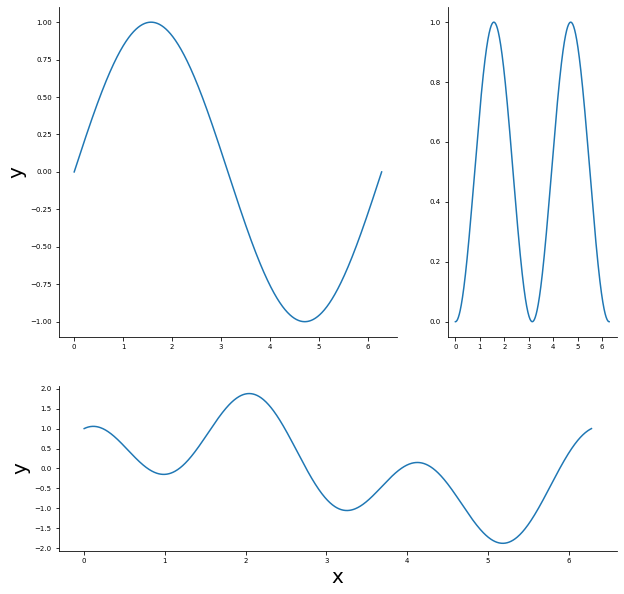

In [7]:
# Styling
# plt.style.use("seaborn-darkgrid")
# plt.rcParams["font.family"] = "Avenir"
# plt.rcParams["font.size"] = 16
# Create Blank Figure
fig = plt.figure(figsize=(10, 10))
# Create 4x4 Grid
gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[2, 1], width_ratios=[2, 1])
# Create Three Axes Objects
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
# Dummy Data

x = np.linspace(0, 2*np.pi, 1000)
# Plot Data
ax1.plot(x, np.sin(x))
ax2.plot(x, np.sin(x)**2)
ax3.plot(x, np.sin(x) + np.cos(3*x))
# Set axis labels
ax1.set_ylabel("y", size=20)
ax3.set_xlabel("x", size=20)
ax3.set_ylabel("y", size=20)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


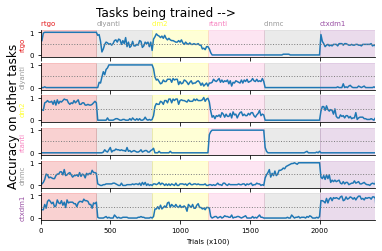

In [8]:
exp_name='same_net'
logs, files = get_logs_and_files(folder_name, exp_name, file_sig='testing_log')
training_logs, files = get_logs_and_files(folder_name, exp_name, file_sig='training_log')
configs, files = get_logs_and_files(folder_name, exp_name, file_sig='config')

idx = 1
testing_log = logs[1]
config = configs[1]
training_log = training_logs[1]
label = exp_name

config.tasks = config.tasks[:6]
no_of_values = 12
norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
cmap_obj = matplotlib.cm.get_cmap('Set1') # tab20b
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)

log = testing_log
training_log.switch_trialxxbatch.append(training_log.stamps[-1])
num_tasks = len(config.tasks)
already_seen =[]
title_label = 'Training tasks sequentially ---> \n    ' + config.exp_name
max_x = training_log.switch_trialxxbatch[num_tasks] #* config.print_every_batches
fig, axes = plt.subplots(num_tasks,1, figsize=[6,3.5])
for i, (tid, tn) in enumerate(config.tasks_id_name[:num_tasks]):
        # print(f'currently plot i {i} tid: {tid}  and tn {tn} ')
        ax = axes[ i ] # log i goes to the col direction -->
        ax.set_ylim([-0.1,1.1])
        ax.set_xlim([0, max_x])
#         ax.axis('off')
        ax.plot(log.stamps, [test_acc[tid] for test_acc in log.accuracies], linewidth=1.5)
        ax.plot(log.stamps, np.ones_like(log.stamps)*0.5, ':', color='grey', linewidth=1)
        ax.set_ylabel(tn[7:-3], fontdict={'color': cmap.to_rgba(tid)})
        for ri in range(len(training_log.switch_trialxxbatch)-1):
                ax.axvspan(training_log.switch_trialxxbatch[ri], training_log.switch_trialxxbatch[ri+1], color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.2)
        xtl = ax.get_xticklabels()
        if not (i +1== num_tasks):        ax.set_xticklabels([])
for ti, id in enumerate(training_log.switch_task_id):
    if id not in already_seen:
        if len(already_seen) >= num_tasks: break # do not go beyond how many tasks are to be displayed
        already_seen.append(id)
        task_name = config.human_task_names[id]
        # print(id)
        task_name = config.human_task_names[id]
        axes[0].text(training_log.switch_trialxxbatch[ti], 1.3, task_name, color= cmap.to_rgba(id) )
axes[0].text(400, 1.7, 'Tasks being trained -->', color= 'black', fontsize=12 ,)
axes[4].text(-0.1, 0.1, 'Accuracy on other tasks', color= 'black', fontsize=12 ,rotation=90, transform=axes[4].transAxes)
axes[-1].set_xlabel('Trials (x100)')
# plt.savefig('coloredfull.jpg', dpi=300)

# Figure 2

Text(0.5, 0, 'Trials (x100)')

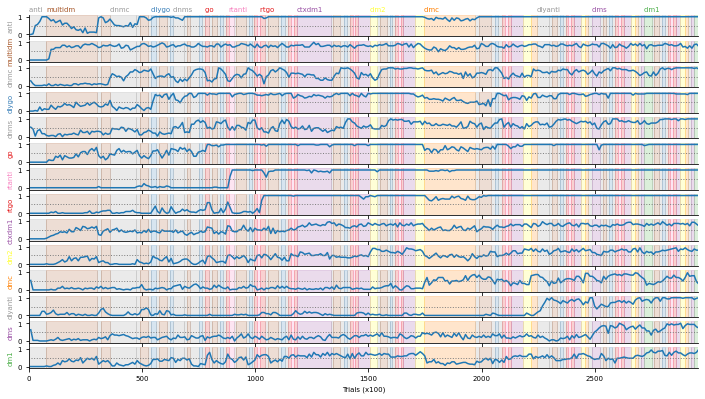

In [9]:
exp_name='random_gates_mul'
logs, files = get_logs_and_files(folder_name, exp_name, file_sig='testing_log')
training_logs, files = get_logs_and_files(folder_name, exp_name, file_sig='training_log')
configs, files = get_logs_and_files(folder_name, exp_name, file_sig='config')

idx = 3
testing_log = logs[idx]
config = configs[idx]
training_log = training_logs[idx]
label = exp_name

config.tasks = config.tasks[:14]
no_of_values = 12
norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
cmap_obj = matplotlib.cm.get_cmap('Set1') # tab20b
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)

log = testing_log
training_log.switch_trialxxbatch.append(training_log.stamps[-1])
num_tasks = len(config.tasks)
already_seen =[]
title_label = 'Training tasks sequentially ---> \n    ' + config.exp_name
max_x = training_log.start_optimizing_at #training_log.switch_trialxxbatch[num_tasks] #* config.print_every_batches
fig, axes = plt.subplots(num_tasks,1, figsize=[12,6.5])
for i, (tid, tn) in enumerate(config.tasks_id_name[:num_tasks]):
        # print(f'currently plot i {i} tid: {tid}  and tn {tn} ')
        ax = axes[ i ] # log i goes to the col direction -->
        ax.set_ylim([-0.1,1.1])
        ax.set_xlim([0, max_x])
#         ax.axis('off')
        ax.plot(log.stamps, [test_acc[tid] for test_acc in log.accuracies], linewidth=1.5)
        ax.plot(log.stamps, np.ones_like(log.stamps)*0.5, ':', color='grey', linewidth=1)
        ax.set_ylabel(tn[7:-3], fontdict={'color': cmap.to_rgba(tid)})
        for ri in range(len(training_log.switch_trialxxbatch)-1):
                ax.axvspan(training_log.switch_trialxxbatch[ri], training_log.switch_trialxxbatch[ri+1], color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.2)
        xtl = ax.get_xticklabels()
        if not (i +1== num_tasks):        ax.set_xticklabels([])
for ti, id in enumerate(training_log.switch_task_id):
    if id not in already_seen:
        if len(already_seen) >= num_tasks: break # do not go beyond how many tasks are to be displayed
        already_seen.append(id)
        task_name = config.human_task_names[id]
        # print(id)
        task_name = config.human_task_names[id]
        axes[0].text(training_log.switch_trialxxbatch[ti], 1.3, task_name, color= cmap.to_rgba(id) )
# axes[0].text(400, 1.7, 'Tasks being trained -->', color= 'black', fontsize=12 ,)
# axes[4].text(-0.1, 0.1, 'Accuracy on other tasks', color= 'black', fontsize=12 ,rotation=90, transform=axes[4].transAxes)
axes[-1].set_xlabel('Trials (x100)')
# plt.savefig('coloredfull.jpg', dpi=300)

In [81]:
# logs, lfilename = get_logs_and_files(folder_name, 'rehearsal')
def get_ttcs_per_task_position(training_log, rehearsal_no=1):

    # print('swtch \ttid \t rehNo \t ttc \t order')
    times_seen = []
    order_learned = []
    ttc = []
    np_task_id = np.array(training_log.switch_task_id)
    np_stamps = training_log.switch_trialxxbatch + [training_log.start_testing_at]
    for i in range(len(training_log.switch_trialxxbatch)):
        times_seen.append( np.sum( np_task_id[:i]== training_log.switch_task_id[i]))
        order_learned.append(np.sum( np.array(times_seen)== times_seen[-1]))
        ttc.append(np_stamps[i+1]- np_stamps[i])
    rttc = np.array(ttc)[np.array(times_seen)==rehearsal_no]
    
# for i in (range(12)):
        # print(log.switch_trialxxbatch[i], '\t', log.switch_task_id[i], '\t', times_seen[i], '\t', ttc[i], '\t', order_learned[i])
    # rehearsal_ttcs = [reh for reh in rehearsal_ttcs if len(reh)>0]
    
    return( rttc, times_seen)

rt, ts = get_ttcs_per_task_position(training_log, 1)


In [85]:
print(ts)
print(len(ts))

[0, 0, 1, 1, 0, 2, 2, 1, 0, 3, 3, 2, 1, 0, 4, 4, 3, 2, 1, 0, 5, 5, 4, 3, 2, 1, 0, 6, 6, 5, 4, 3, 2, 1, 0, 7, 7, 6, 5, 4, 3, 2, 1, 0, 8, 8, 7, 6, 5, 4, 3, 2, 1, 0, 9, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 10, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 11, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 12, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 13, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 14, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
134


In [61]:
folder_name = './../files/final_bu2/'

experiments = ['same_net', 'random_gates_only', 'train_to_criterion', 'random_gates_no_rehearsal' , 'rehearsal','random_gates_mul',   'random_gates_rehearsal_no_train_to_criterion'  ]# ]# 'cognitive_observer', ]
exp_name = 'random_gates_mul'
seed = 2
var1 = 0.0
var2 = 1.0
var3 = 1.0
no_of_tasks = 14
var4  = 1.0
def load_simulation(data_folder, exp_name, seed, var1, var2, var3, var4, no_of_tasks):
    search_strs=[f'seed{seed}_', f'tasks_{no_of_tasks}_{var1:3.1f}_{var3:1.1f}_{var4:1.1f}']
    testing_logs, test_files = get_logs_and_files(data_folder, exp_name, file_sig='testing_log', search_strs=search_strs)
    training_logs, train_files = get_logs_and_files(data_folder, exp_name, file_sig='training_log', search_strs=search_strs)
    configs, config_files = get_logs_and_files(data_folder, exp_name, file_sig='config', search_strs=search_strs)
    config_files
    
    if len(training_logs) > 0:
        testing_log = testing_logs[0]
        training_log = training_logs[0]
        config = configs[0]
        assert len(training_logs) == 1, 'more than one training_log found!'
    else:
        print( f'unable to load {search_strs}!')
        testing_log, training_log, config = None, None, None        
    return config,training_log,testing_log


config, training_log, testing_log = load_simulation(folder_name, exp_name, seed, var1, var2, var3, var4, no_of_tasks)

data = defaultdict(list)
no_of_tasks = 14

Seeds = range(5)
Var1 = [0.0, ] #[(x/10) for x in [10]]#range(5,14, 2)] # gates_mean  #0 1 add mul 
Var2 = [1.0] # used to pass no of exp  #[-0.3] #MDprob, currently gaussian cuttoff #[0.0001, 0.001]#range(0,3, 1) #gates mean
Var3 = [1.0] # [(x/10) for x in range(1,5, 1)] #gates_std  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
Var4 = [1.0] # [(x/10) for x in range(0,6, 4)] #gates_sparsity  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]

# expVars =  [[seed, experiment, x1, x2, x3, x4] for seed in Seeds for experiment in experiments for x1 in Var1 for x2 in Var2 for x3 in Var3 for x4 in Var4 ]
expVars =  [[seed,  x1, x2, x3, x4] for seed in Seeds for x1 in Var1 for x2 in Var2 for x3 in Var3 for x4 in Var4 ]
for jobi, par_set in enumerate(expVars):
    seed, var1, var2, var3, var4 = par_set
    config, training_log, testing_log = load_simulation(folder_name, exp_name, seed, var1, var2, var3, var4, no_of_tasks)
    if not config is None: # if exp actually loaded and exists.
        exps.append({'var1': var1, 'var2': var2, 'var3': var3, 'no_of_tasks': no_of_tasks, 'seed': seed, 'var4': var4})
        data['ttcs'].append(training_log.trials_to_crit[:])
        data['total_batches'].append(training_log.stamps[-1])
        data['ttcs_new'].append(get_ttcs_per_task_position(training_log, rehearsal_no=0))
        data['ttcs_first'].append(get_ttcs_per_task_position(training_log, rehearsal_no=1))
        data['ttcs_second'].append(get_ttcs_per_task_position(training_log, rehearsal_no=2))





### Not enough seeds. Also run training not optim. Need to re run these. 

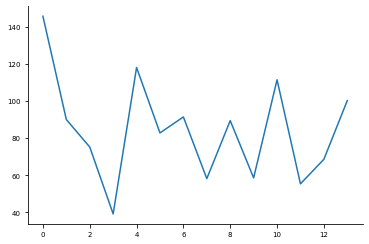

In [62]:
plt.plot(np.mean(np.stack(data['ttcs_new']), 0))

In [63]:
experiments = [ 'shuffle_add', 'shuffle_mul', 'random_gates_add', 'random_gates_mul',]
experiments = [  'shuffle_mul','random_gates_mul','shuffle_add','random_gates_add','random_gates_both',]
experiments = [ 'shuffle_mul', 'random_gates_mul']
folder_name = './../files/forgetting_measure_14_tasks_fixed_to_crit_equal_training/'


In [64]:
def get_negative_and_absolute_acc_changes_after_learning(task_order):
    end_of_previous = training_log.switch_trialxxbatch[task_order] - 1 # the switch_trialxxbatch marks begning of task.
    testing_stamp_before = convert_train_to_test_idx(training_log, testing_log, end_of_previous) 
    end_of_task = training_log.switch_trialxxbatch[task_order] + training_log.trials_to_crit[task_order] 
    testing_stamp_after = convert_train_to_test_idx(training_log, testing_log, end_of_task) 

    # get accuracies exluding the accs for the current task.
    test_idx = testing_stamp_before
    accs_before = [testing_log.accuracies[test_idx][idx] for idx in testing_log.accuracies[test_idx].keys() if not idx == training_log.task_ids[task_order]]
    test_idx = testing_stamp_after
    accs_after = [testing_log.accuracies[test_idx][idx] for idx in testing_log.accuracies[test_idx].keys() if not idx == training_log.task_ids[task_order]]

    diffs = np.array(accs_after) - np.array(accs_before)
    negatives = diffs[diffs<0.] # get only change in accuracy where forgetting happened. 
    if len(negatives) < 1:
        negatives = np.array([0]) # otherwise you will get nan when you take means later.
    absolutes = np.abs(diffs) # get the absolute changes, as a measure of interference.
    return(negatives, absolutes)

In [102]:
negatives_or_absolutes = 1 # 0 for negative changes only, 1 for abs values.
exps = experiments
accuracy_dict = {}
total_trials_dict={}
novel_and_rehearsal_totals_dict = {}
novel_and_rehearsal_ttcs_dict = {}
forgettings_dict = {}
average_acc_dict = {}
for exp_name in exps:
    testing_logs, test_files = get_logs_and_files(folder_name, exp_name, file_sig='testing_log')
    training_logs, train_files = get_logs_and_files(folder_name, exp_name, file_sig='training_log')
    configs, config_files = get_logs_and_files(folder_name, exp_name, file_sig='config')
    mean_accuracies = []
    totals = []
    novel_and_rehearsal_totals = []
    novel_and_rehearsal_ttcs = []
    forgettings = []
    average_acc =[]
    for (testing_log, training_log,config) in (zip(testing_logs, training_logs, configs)):
        final_accuracy_average = np.mean(list(testing_log.accuracies[-1].values()))
        mean_accuracies.append(final_accuracy_average)
        totals.append(testing_log.total_batches)
        novel_and_rehearsal_totals.append(testing_log.stamps[-1] - testing_log.start_testing_at)
        novel_reh_novel_no_of_tasks = 16
        novel_and_rehearsal_ttcs.append(training_log.trials_to_crit[-novel_reh_novel_no_of_tasks:])
        means = [np.mean(get_negative_and_absolute_acc_changes_after_learning(ti)[negatives_or_absolutes] )for ti in range(2,len(training_log.switch_task_id)-1)]
        forgettings.append(means)
        # avg
        taa = []
        for logi in range(15):
            taa.append([test_acc[logi] for test_acc in testing_log.accuracies])
        average_acc.append(np.stack(taa))
        
    accuracy_dict.update({exp_name: np.stack(mean_accuracies)})
    total_trials_dict.update({exp_name: np.stack(totals)})
    novel_and_rehearsal_totals_dict.update({exp_name: np.stack(novel_and_rehearsal_totals)})
    novel_and_rehearsal_ttcs_dict.update({exp_name: np.stack(novel_and_rehearsal_ttcs)})
    average_acc_dict.update({exp_name: (average_acc)})
    forgettings_dict.update({exp_name: np.stack(forgettings)})

KeyboardInterrupt: 

In [ ]:
forgettings_dict[exp_name][np.isnan(forgettings_dict[exp_name])] =0.

In [ ]:
times_seen = []
np_task_id = np.array(training_log.switch_task_id)
np_stamps = training_log.switch_trialxxbatch + [training_log.start_testing_at]
for i in range(len(training_log.switch_trialxxbatch)):
    times_seen.append( np.sum( np_task_id[:i]== training_log.switch_task_id[i]))

In [ ]:
print(times_seen)
print(len(times_seen))
forgettings_dict[exp_name] #.shape #(9, 131) # the first 2 tasks are cut off and the last one..


[0, 0, 1, 1, 0, 2, 2, 1, 0, 3, 3, 2, 1, 0, 4, 4, 3, 2, 1, 0, 5, 5, 4, 3, 2, 1, 0, 6, 6, 5, 4, 3, 2, 1, 0, 7, 7, 6, 5, 4, 3, 2, 1, 0, 8, 8, 7, 6, 5, 4, 3, 2, 1, 0, 9, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 10, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 11, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 12, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 13, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 14, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
134


Text(0.5, 1.0, 'sequential forgettings')

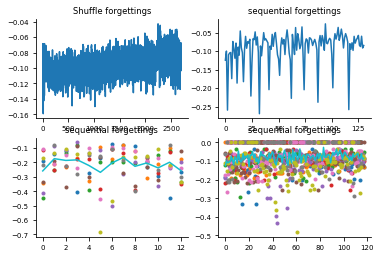

In [ ]:
fig, axes = plt.subplots(2,2)
ax = axes[0,0]
exp_name = 'shuffle_mul' #'random_gates_mul'
ax.plot(forgettings_dict[exp_name].mean(0)[1:-15])
ax.set_title('Shuffle forgettings')
ax = axes[0,1]
exp_name = 'random_gates_mul'
ax.plot(forgettings_dict[exp_name].mean(0))
ax.set_title('sequential forgettings')
ax = axes[1,1]
exp_name = 'random_gates_mul'
# ax.plot(forgettings_dict[exp_name].T, '.')
ax.plot(forgettings_dict[exp_name].T[np.array(times_seen)[2:-1] != 0], '.')
ax.plot(forgettings_dict[exp_name].T[np.array(times_seen)[2:-1] != 0].mean(1), )
ax.set_title('sequential forgettings')
ax = axes[1,0]
exp_name = 'random_gates_mul'
ax.plot(forgettings_dict[exp_name].T[np.array(times_seen)[2:-1] == 0], '.')
ax.plot(forgettings_dict[exp_name].T[np.array(times_seen)[2:-1] == 0].mean(1), )
ax.set_title('sequential forgettings')

(9, 131)